In [1]:
# -*- coding: utf-8 -*-

## Map Generalization for Polygons using Autoencode-like strucutures
## Adatped based on Master Thesis of SERCAN CAKIR "ROAD NETWORK EXTRACTION USING CNN"
## Author: Yu Feng, yuzz.feng@gmail.com
## 1. Version Author: SERCAN CAKIR

## Changes:
## 1. Two conv layers were added before the first down convlusional layer
## 2. Output can be any size during the evaluation
## 3. Adapt the code to support more images as training examples
## 4. Dropouot may make the sharpe corners vanishing, we delete half of them, but we should used some
## 5. 

import matplotlib
#matplotlib.use('Agg') # necessary for linux kernal
%matplotlib inline
import matplotlib.pyplot as plt

import os
import numpy as np
from numpy import random
np.random.seed(7)
import keras
from keras.models import Sequential
from keras.callbacks import History
from keras.layers.core import Dropout
#from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.layers import MaxPooling2D, Conv2DTranspose, BatchNormalization, Activation
from keras import backend as K

from keras.models import Model
from keras.layers import Input, Conv2D, Dropout, UpSampling2D, Activation, Concatenate

from osgeo import gdal
from sklearn.model_selection import train_test_split
from skimage.util.shape import view_as_windows

from data_helper import readImg, readImgInv, imagePatches, removeBlackImg, removeCorrespondence, check_and_create

from time import gmtime, strftime
timestr = strftime("%Y-%m-%d %H-%M-%S", gmtime())

def prediction_independent(model_ex1, image_arr):
    
    conc2 = np.reshape(model_ex1.predict(np.reshape(image_arr, (1, image_arr.shape[0], image_arr.shape[1], 1))), 
                   (image_arr.shape[0], image_arr.shape[1]))
    return conc2


############ Path Setting ##############

trainPath = r"Data/Training_Validation/"

trainPath = r"Data/geb10/"


testPath = r"Data/Testing/"
tmpPath = r"../tmp_data/"

outPath = r"Prediction/"
check_and_create(outPath + timestr)
outPath = outPath + timestr + "/"

Using TensorFlow backend.


## Models

In [2]:
import keras.backend as K
import tensorflow as tf
from keras.losses import binary_crossentropy

_EPSILON = 10e-8

def IoU(yTrue,yPred):  
    
    I = tf.multiply(yTrue, yPred, name="intersection")
    U = yTrue + yPred - I + _EPSILON
    
    IoU = tf.reduce_sum(I) / tf.reduce_sum(U)
    return -tf.log(IoU + _EPSILON) + binary_crossentropy(yTrue,yPred)
    
    #IoU = tf.divide(I, U, name='IoU')
    #L = -tf.log(IoU + _EPSILON)
    #return tf.reduce_mean(L)
    
    
def MSE_CROSS(yTrue,yPred):
    return binary_crossentropy(yTrue,yPred) + K.abs(K.sum(yTrue) - K.sum(yPred))

## Prepare Training Data

In [8]:
# Order the image dimension acc. to TensorFlow (batc_hsize, rows, cols, channels)
K.set_image_dim_ordering('tf')

# set the working directory
#os.chdir(r'F:\sercan\input_images')
PATH = os.getcwd()
#plt.gray()
#plt.show()


p_size_1 = 128 # Compared with 256, which larger may generate round corners

In [9]:
# save image patch arrays
x_train_sim = np.load(tmpPath + "x_train_sim.npy")
y_train_sim = np.load(tmpPath + "y_train_sim.npy")
x_test_sim = np.load(tmpPath + "x_test_sim.npy")
y_test_sim = np.load(tmpPath + "y_test_sim.npy")

Input Shape of the models (35083, 128, 128, 1)
Tet Shape of the models (1000, 128, 128, 1)


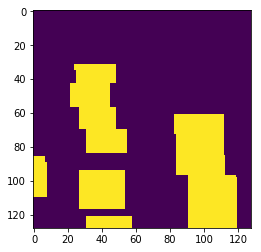

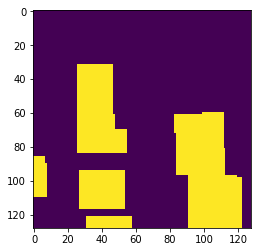

In [11]:
plt.figure()
plt.imshow(np.reshape(x_test_sim[2], (p_size_1,p_size_1)))
plt.figure()
plt.imshow(np.reshape(y_test_sim[2], (p_size_1,p_size_1)))

input_shape1 = (None, None, 1) #x_train_sim[0].shape
print('Input Shape of the models', x_train_sim.shape)
print('Tet Shape of the models', x_test_sim.shape)

In [12]:
opt1 = keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0)
#opt1 = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

#model_ex1 = create_model(opt1, input_shape1)

#model_ex1 = create_model_batch(opt1, input_shape1) # Not good as the skip connection

#model_ex1 = create_model_add_skips(opt1, input_shape1)

model_ex1 = create_model_add_skips_2(opt1, input_shape1)

#model_ex1 = create_model_add_skips_3(opt1, input_shape1) # Add max pool but not better

model_ex1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 1 0                                            
__________________________________________________________________________________________________
flat_conv_a (Conv2D)            (None, None, None, 2 240         input_1[0][0]                    
__________________________________________________________________________________________________
flat_conv_b (Conv2D)            (None, None, None, 2 5208        flat_conv_a[0][0]                
__________________________________________________________________________________________________
down_conv_1 (Conv2D)            (None, None, None, 2 5208        flat_conv_b[0][0]                
__________________________________________________________________________________________________
flat_conv_

In [13]:
import itertools
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [ ]:
data_gen_args = dict(rotation_range=180.)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

seed = 1
BATCH_SIZE = 16
result_generator = zip(image_datagen.flow(x_train_sim, batch_size=BATCH_SIZE, seed=seed), 
                       mask_datagen.flow(y_train_sim, batch_size=BATCH_SIZE, seed=seed))

History1 = History()
hist1 = model_ex1.fit_generator(  result_generator,
                                  epochs = 50,
                                  steps_per_epoch=5000,
                                  verbose=1,
                                  shuffle=True,
                                  callbacks=[History1, 
                                             EarlyStopping(patience=10), 
                                             ReduceLROnPlateau(patience = 3, verbose = 0),
                                             ModelCheckpoint(outPath + "weights.hdf5", 
                                                             save_best_only = True, 
                                                             save_weights_only = False)],
                                  validation_data=(x_test_sim, y_test_sim))

Epoch 1/50
5000/5000 [==============================] - 407s 81ms/step - loss: 0.0365 - acc: 0.9693 - val_loss: 0.0252 - val_acc: 0.9940
Epoch 2/50
5000/5000 [==============================] - 484s 97ms/step - loss: 0.0318 - acc: 0.9705 - val_loss: 0.0238 - val_acc: 0.9941
Epoch 3/50
5000/5000 [==============================] - 471s 94ms/step - loss: 0.0308 - acc: 0.9705 - val_loss: 0.0237 - val_acc: 0.9942
Epoch 4/50
3785/5000 [=====================>........] - ETA: 1:48 - loss: 0.0304 - acc: 0.9705

## Training

In [ ]:
import os
import numpy as np
import pandas as pd
from data_helper import predict_15k, save_hist, save_model

### Save history
save_hist(History1, outPath)
### Save model
#save_model(model_ex1, outPath)
# Retain best model
#from keras import models
#model_ex1 = models.load_model(outPath + "weights.hdf5")

## Independent Test

In [ ]:
all_records = []

records = predict_15k(outPath, testPath, outPath, 
                      r"FTest1_input_inv.png", r"FTest1_output_inv.png")
all_records.extend(records)

records = predict_15k(outPath, testPath, outPath, 
                      r"FTest2_input_inv.png", r"FTest2_output_inv.png")
all_records.extend(records)

df = pd.DataFrame(np.transpose(all_records))
df.columns = ["Input vs Target (Test1)", "Prediction vs Target (Test1)", 
              "Input vs Target (Test2)", "Prediction vs Target (Test2)"]

df = df.rename({0: "Accuracy", 1: 'IoU'})
df.index.name = 'Metrics'
df